In [2]:
import jupyter_black

jupyter_black.load()

In [10]:
import json
import re
from pathlib import Path

import numpy as np
import pandas as pd
from protein_name_mapping import dpp_protein_mapping


In [11]:
base_path = Path("../../data/dpp4")
base_path = Path("../../data/dpp4")
fasta_path = base_path / "dpp.fasta"

paths = [
    base_path / "dpp4.json",
    base_path / "dpp6.json",
    base_path / "dpp8.json",
    base_path / "dpp9.json",
    base_path / "dpp10.json",
    base_path / "FAP.json",
    base_path / "misc.json",
]

data = dict()
for path in paths:
    print(path.stem)
    with open(path) as file:
        load_data = json.load(file)
        data[path.stem] = load_data

dpp4
dpp6
dpp8
dpp9
dpp10
FAP
misc


In [143]:
dfs = list()
for gene_name, d in data.items():
    uids = list()
    taxons = list()
    markers = list()
    protein_names = list()
    seqs = list()
    genes = list()
    annotation_scores = list()
    for entry in list(d.values())[0]:
        entry_type = re.match(r".*\((.*)\)", entry["entryType"]).groups()[0]
        uid = entry["primaryAccession"]
        annotation_score = entry["annotationScore"]
        # taxonomy
        taxon_id = entry["organism"]["taxonId"]
        name = entry["organism"]["scientificName"]
        lineage = entry["organism"]["lineage"]
        taxonomy = entry["organism"]["lineage"] + [name]
        seq = entry["sequence"]["value"]
        if "X" in seq:
            continue

        # existence
        protein_existence = entry["proteinExistence"]
        if name == "Homo sapiens":
            marker = name
        elif "Apis" in taxonomy:
            marker = "Apis"
        elif "Serpentes" in taxonomy:
            marker = "Serpentes"
        else:
            marker = np.nan

        # --- protein name ---
        names = entry["proteinDescription"]
        if "recommendedName" in names:
            protein_name = names["recommendedName"]["fullName"]["value"]
        elif "submissionNames" in names:
            protein_name = names["submissionNames"][0]["fullName"]["value"]
        else:
            print(names)
            break
        # --- marker ---
        if "Venom" in protein_name:
            marker2 = "venom"
        else:
            marker2 = np.nan
        uids.append(uid)
        taxons.append(taxonomy[-6])
        # taxons.append(name)
        markers.append(marker)
        protein_names.append(protein_name)
        seqs.append(seq)
        annotation_scores.append(annotation_score)
    df = pd.DataFrame(
        {
            "uid": uids,
            "taxon": taxons,
            "marker": markers,
            "protein_name": protein_names,
            "seq": seqs,
            "annotation_score": annotation_scores,
        }
    )
    df["gene"] = gene_name
    dfs.append(df)

df = pd.concat(dfs)
df = df.reset_index(drop=True)
df = df.drop_duplicates(subset="uid")
df["protein_name"] = df["protein_name"].apply(dpp_protein_mapping)

<Axes: ylabel='Frequency'>

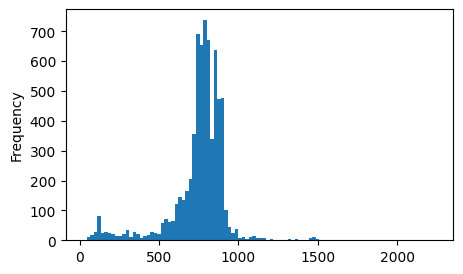

In [151]:
df["seq"].str.len().plot(kind="hist", bins=100, figsize=(5, 3))

In [170]:
with open(fasta_path, "w") as handle:
    for idx, row in df.iterrows():
        handle.write(f">{row['uid']}\n")
        handle.write(f"{row['seq']}\n")
df.to_csv(base_path / "dpp.csv", index=False)

In [169]:
df["seq"].str[0].value_counts()

seq
M    5732
L     182
S     121
I      95
V      86
F      83
Q      62
P      61
A      57
T      52
K      52
G      49
R      44
E      42
N      42
Y      39
C      38
H      29
W      19
D      18
Name: count, dtype: int64

## mmseqs2: redundancy reduction

In [152]:
df["gene"].value_counts()

gene
dpp4     1990
dpp9     1617
dpp10    1572
dpp8      730
dpp6      630
FAP       330
misc       34
Name: count, dtype: int64

In [153]:
base_path = Path("../../data/dpp4")
data_name = "dpp4"
fasta_path = base_path / f"{data_name}.fasta"
seq_id = 0.9

with open(fasta_path, "w") as handle:
    for idx, row in df.iterrows():
        if row["gene"] != data_name:
            continue
        handle.write(f">{row['uid']}\n")
        handle.write(f"{row['seq']}\n")

In [155]:
import shutil

mmseqs_dir = base_path / "mmseqs"
work_dir = mmseqs_dir / data_name
db_path = work_dir / f"DB_{data_name}"
clu_path = work_dir / f"DB_{data_name}_clu"
tsv_path = work_dir / f"DB_{data_name}_clu.tsv"
tmp_path = work_dir / "tmp"

if work_dir.exists():
    shutil.rmtree(work_dir)
work_dir.mkdir(exist_ok=True)
# !rm -r {work_dir}
# !mkdir {work_dir}

!mmseqs createdb {fasta_path} {db_path}
!mmseqs cluster {db_path} {clu_path} {tmp_path} --min-seq-id {seq_id} -c 0.8 --alignment-mode 3 --cov-mode 3 -s 7.5 --comp-bias-corr 0 --mask 0
!mmseqs createtsv {db_path} {db_path} {clu_path} {tsv_path}

createdb ../../data/dpp4/dpp4.fasta ../../data/dpp4/mmseqs/dpp4/DB_dpp4 

MMseqs Version:       	14-7e284
Database type         	0
Shuffle input database	true
Createdb mode         	0
Write lookup file     	1
Offset of numeric ids 	0
Compressed            	0
Verbosity             	3

Converting sequences


[1920] 0s 51ms
Time for merging to DB_dpp4_h: 0h 0m 0s 18ms
Time for merging to DB_dpp4: 0h 0m 0s 15ms
Database type: Aminoacid
Time for processing: 0h 0m 0s 190ms
Create directory ../../data/dpp4/mmseqs/dpp4/tmp
cluster ../../data/dpp4/mmseqs/dpp4/DB_dpp4 ../../data/dpp4/mmseqs/dpp4/DB_dpp4_clu ../../data/dpp4/mmseqs/dpp4/tmp --min-seq-id 0.9 -c 0.8 --alignment-mode 3 --cov-mode 3 -s 7.5 --comp-bias-corr 0 --mask 0 

MMseqs Version:                     	14-7e284
Substitution matrix                 	aa:blosum62.out,nucl:nucleotide.out
Seed substitution matrix            	aa:VTML80.out,nucl:nucleotide.out
Sensitivity                         	7.5
k-mer length                        	0
k-score                             	seq:2147483647,prof:2147483647
Alphabet size                       	aa:21,nucl:5
Max sequence length                 	65535
Max results per query               	20
Split database                      	0
Split mode                          	2
Split memory limit           

In [158]:
def parse_clusters(cluster_tsv, df):
    df_clu = pd.read_csv(
        cluster_tsv, sep="\t", header=None, names=["representative", "member"]
    )
    rep = df_clu["representative"].unique()
    df_rep = df.loc[df["uid"].isin(rep), :]
    # df_rep["Pharmacological Family"].value_counts()
    return df_clu, df_rep


# df = pd.DataFrame(list(seqs.items()), columns=["uid", "seq"])
df_clu, df_rep = parse_clusters(cluster_tsv=tsv_path, df=df)

In [164]:
df_clu.groupby("representative")

In [ ]:
import os
import subprocess

import pandas as pd
from Bio import SeqIO


# Function to run shell commands
def run_command(command):
    process = subprocess.Popen(
        command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE
    )
    stdout, stderr = process.communicate()
    return stdout, stderr


# Step 1: Cluster sequences with MMseqs2
mmseqs_command = "mmseqs easy-cluster input.fasta clusterResult tmp --min-seq-id 0.9"
stdout, stderr = run_command(mmseqs_command)
if stderr:
    print("Error in MMseqs2 clustering:", stderr.decode())
else:
    print("Clustering completed.")

# Step 2: Read the clustering result
cluster_file = "clusterResult_cluster.tsv"
if not os.path.exists(cluster_file):
    print("Cluster file not found.")
else:
    # Read cluster file
    clusters = pd.read_csv(
        cluster_file, sep="\t", header=None, names=["cluster_id", "sequence_id"]
    )

    # Count sequences in each cluster
    cluster_counts = clusters["cluster_id"].value_counts()

    # Identify singletons and small clusters
    outlier_clusters = cluster_counts[
        cluster_counts <= 3
    ].index.tolist()  # Adjust the threshold as needed

    # Filter out outliers
    outliers = clusters[clusters["cluster_id"].isin(outlier_clusters)]

    # Step 3: Remove outliers from original dataset
    def filter_sequences(input_file, output_file, exclude_ids):
        sequences = SeqIO.parse(input_file, "fasta")
        filtered = (seq for seq in sequences if seq.id not in exclude_ids)
        SeqIO.write(filtered, output_file, "fasta")

    filter_sequences("input.fasta", "cleaned.fasta", set(outliers["sequence_id"]))
    print("Outlier sequences removed. Cleaned dataset saved as 'cleaned.fasta'.")

In [153]:
def parse_clusters(cluster_tsv, df):
    df_clu = pd.read_csv(
        cluster_tsv, sep="\t", header=None, names=["representative", "member"]
    )
    rep = df_clu["representative"].unique()
    df_rep = df.loc[df["uid"].isin(rep), :]
    # df_rep["Pharmacological Family"].value_counts()
    return df_clu, df_rep


df = pd.DataFrame(list(seqs.items()), columns=["uid", "seq"])
df_clu, df_rep = parse_clusters(cluster_tsv=output_paths["createtsv"], df=df)

In [154]:
with open(base_path / "dpp4_90.fasta", "w") as handle:
    for idx, row in df_rep.iterrows():
        handle.write(f">{row['uid']}\n")
        handle.write(f"{row['seq']}\n")

In [155]:
len(df_rep)

307

## create CSV

In [169]:
uids = list()
taxons = list()
for entry in list(dpp4_data.values())[0]:
    entry_type = re.match(r".*\((.*)\)", entry["entryType"]).groups()[0]
    uid = entry["primaryAccession"]
    annotation_score = entry["annotationScore"]
    uids.append(uid)
    # taxonomy
    taxon_id = entry["organism"]["taxonId"]
    name = entry["organism"]["scientificName"]
    lineage = entry["organism"]["lineage"]
    taxonomy = entry["organism"]["lineage"] + [entry["organism"]["scientificName"]]
    taxons.append(taxonomy[4])
    # taxons.append(name)
    # existence
    protein_existence = entry["proteinExistence"]
    # if "keywords" in entry:
    #     print(entry["keywords"])
    #     break
    # break

In [170]:
for kw in entry["keywords"]:
    name = kw["name"]
    category = kw["category"]
    kw_id = kw["id"]
    print(kw_id, name, category)

KW-0472 Membrane Cellular component
KW-0812 Transmembrane Domain
KW-1133 Transmembrane helix Domain


In [172]:
df = pd.DataFrame({"uids": uids, "taxon": taxons})
df.to_csv(base_path / "dpp4_tmp.csv", index=False)

In [173]:
df["taxon"].value_counts().to_dict()

{'Vertebrata': 1784,
 'Hexapoda': 522,
 'Mollusca': 59,
 'Chelicerata': 54,
 'Crustacea': 27,
 'Chromadorea': 14,
 'Leptocardii': 10,
 'Platyhelminthes': 9,
 'Hexacorallia': 6,
 'Enoplea': 5,
 'Hydroidolina': 3,
 'Myxosporea': 2,
 'Trichoplacea': 2,
 'Octocorallia': 2,
 'Eutardigrada': 1,
 'Echinozoa': 1}

- get the 10 species with the largest taxonomic distance between them having a BUSCO score of at least 90% from all Metazoas
- Distance defenition:
  - travers the taxonomy tree where the distance to each parent and to each child is 1
    - vectorize: `set(taxon1) ^ set(taxon2)`
  - get years it took to evolve from one species to another

In [70]:
entry.keys()

dict_keys(['entryType', 'primaryAccession', 'uniProtkbId', 'entryAudit', 'annotationScore', 'organism', 'proteinExistence', 'proteinDescription', 'genes', 'comments', 'features', 'keywords', 'references', 'uniProtKBCrossReferences', 'sequence', 'extraAttributes'])

In [71]:
def calc_taxon_distance(taxon1, taxon2):
    return len(set(taxon1) ^ set(taxon2))

In [72]:
import itertools

import numpy as np

arr = np.zeros((len(taxons), len(taxons)))
for (idx, jdx), (taxon1, taxon2) in zip(
    itertools.combinations(range(len(taxons)), 2),
    itertools.combinations(taxons, 2),
):
    arr[idx, jdx] = calc_taxon_distance(taxon1, taxon2)
arr

KeyboardInterrupt: 

In [ ]:
print(len(taxonomy))

### create a graph

In [79]:
import networkx as nx


def build_graph_from_taxons(taxons):
    G = nx.DiGraph()
    for lineage in taxons:
        for i in range(len(lineage) - 1):
            parent, child = lineage[i], lineage[i + 1]
            G.add_edge(parent, child)
    return G


def find_leaf_nodes(G):
    return [node for node, degree in G.out_degree() if degree == 0]


def most_distant_leafs(G, x):
    all_paths = dict(nx.floyd_warshall(G))
    leaf_nodes = find_leaf_nodes(G)
    distant_leafs = []

    for i in range(len(leaf_nodes)):
        for j in range(i + 1, len(leaf_nodes)):
            distance = all_paths[leaf_nodes[i]][leaf_nodes[j]]
            distant_leafs.append((leaf_nodes[i], leaf_nodes[j], distance))

    distant_leafs.sort(key=lambda x: x[2], reverse=True)
    return distant_leafs[:x]


# Your taxons data
# taxons = [
#     ['Eukaryota', 'Metazoa', 'Chordata', 'Craniata', 'Vertebrata', 'Euteleostomi', 'Mammalia', 'Eutheria', 'Laurasiatheria', 'Artiodactyla', 'Ruminantia', 'Pecora', 'Bovidae', 'Caprinae', 'Capra', 'Capra hircus'],
#     ['Eukaryota', 'Metazoa', 'Chordata', 'Craniata', 'Vertebrata', 'Euteleostomi', 'Mammalia', 'Eutheria', 'Laurasiatheria', 'Carnivora', 'Feliformia', 'Felidae', 'Felinae', 'Felis', 'Felis catus'],
#     # Add the rest of your taxons here
# ]

G = build_graph_from_taxons(taxons)
# x_most_distant = most_distant_leafs(G, 2)
# print(x_most_distant)

#### Strategy 2:
- **Pre-compute Distance to Leaf:** While building the graph, you can also calculate and store the distance of each node from the leaf.
This can be done by a simple depth-first traversal from the root.
- **Modify Graph Nodes:** Each node in the graph can be a tuple (species, distance_to_leaf).
When searching for distant leaves, you can prioritize paths that lead to nodes with greater distance_to_leaf.

In [83]:
def build_graph_and_compute_distances(taxons):
    G = nx.DiGraph()
    max_depth = {
        node: 0 for lineage in taxons for node in lineage
    }  # Initialize max depth

    for lineage in taxons:
        for i in range(len(lineage) - 1):
            parent, child = lineage[i], lineage[i + 1]
            G.add_edge(parent, child)
            max_depth[child] = max(max_depth[child], len(lineage) - i - 1)

    return G, max_depth


def find_most_distant_leaves(G, max_depth, x):
    leaves = [node for node in G.nodes if G.out_degree(node) == 0]
    leaves.sort(key=lambda leaf: max_depth[leaf], reverse=True)

    # Assuming the tree is balanced, the most distant leaves should be among those with the greatest depth
    return leaves[:x]


G, max_depth = build_graph_and_compute_distances(taxons)
most_distant_leaves = find_most_distant_leaves(
    G, max_depth, 10
)  # Change 2 to the number of leaves you want
print("Most distant leaves:", most_distant_leaves)

Most distant leaves: ['Capra hircus', 'Felis catus', 'Canis lupus familiaris', 'Bos taurus', 'Monodelphis domestica', 'Mus musculus', 'Rattus norvegicus', 'Sus scrofa', 'Homo sapiens', 'Glycine max']


#### Strategy 1:
- Identify Divergence Points: You can identify the earliest divergence points in the tree where the paths to different leaves start to diverge.
- Traverse Downward from These Points: For each divergence point, traverse down the two most distinct paths. The leaves at the ends of these paths are likely to be among the most distant.

In [84]:


def build_graph(taxons):
    G = nx.DiGraph()
    for lineage in taxons:
        for i in range(len(lineage) - 1):
            parent, child = lineage[i], lineage[i + 1]
            G.add_edge(parent, child)
    return G


def find_divergence_points(G):
    divergence_points = []
    for node in G.nodes:
        if G.out_degree(node) > 1:  # More than one child signifies a divergence point
            divergence_points.append(node)
    return divergence_points


def find_distant_leaves_from_divergence(G, divergence_node):
    paths = nx.single_source_shortest_path(G, divergence_node)
    leaf_paths = {end: path for end, path in paths.items() if G.out_degree(end) == 0}

    if not leaf_paths:
        return None  # No leaves found from this divergence point

    # Find two leaves that are most distant from each other
    max_distance = 0
    most_distant_pair = None
    for leaf1 in leaf_paths:
        for leaf2 in leaf_paths:
            if leaf1 != leaf2:
                distance = len(
                    set(leaf_paths[leaf1]) ^ set(leaf_paths[leaf2])
                )  # Unique nodes in both paths
                if distance > max_distance:
                    max_distance = distance
                    most_distant_pair = (leaf1, leaf2)
    return most_distant_pair


# Your taxons data
G = build_graph(taxons)
divergence_points = find_divergence_points(G)
most_distant_leaves = []

for divergence_point in divergence_points:
    leaves = find_distant_leaves_from_divergence(G, divergence_point)
    if leaves:
        most_distant_leaves.append(leaves)

if most_distant_leaves:
    most_distant_leaves = sorted(
        most_distant_leaves,
        key=lambda pair: len(set(G.nodes[pair[0]]) ^ set(G.nodes[pair[1]])),
        reverse=True,
    )[0]
    print("Most distant leaves:", most_distant_leaves)
else:
    print("No distant leaves found")

Most distant leaves: ('Calcarius ornatus', 'Glycine max')


#### strategy 3:

In [85]:
import random


def build_graph(taxons):
    G = nx.DiGraph()
    for lineage in taxons:
        for i in range(len(lineage) - 1):
            parent, child = lineage[i], lineage[i + 1]
            G.add_edge(parent, child)
    return G


def find_divergence_points(G, x):
    divergence_points = []
    for node in G.nodes:
        if G.out_degree(node) > 1:
            divergence_points.append(node)
            if len(divergence_points) == x:
                break
    return divergence_points


def group_leaves_by_divergence(G, divergence_points):
    groups = {}
    for point in divergence_points:
        leaves = [
            n
            for n, d in G.nodes(data=True)
            if G.out_degree(n) == 0 and nx.has_path(G, point, n)
        ]
        groups[point] = leaves
    return groups


def select_representatives(groups, leaf_data):
    representatives = {}
    for group, leaves in groups.items():
        best_leaf = None
        best_score = -1
        best_cdp = float("inf")
        least_missing = float("inf")

        for leaf in leaves:
            data = leaf_data.get(leaf, {})
            busco_score = data.get("BUSCO", -1)
            cdp_status = data.get("CDP status", "Unknown")
            missing = data.get("missing", float("inf"))

            cdp_order = [
                "Standard",
                "Close to standard (high value)",
                "Close to standard (low value)",
                "Outlier (high value)",
                "Outlier (low value)",
                "Unknown",
            ]
            cdp_rank = cdp_order.index(cdp_status)

            if (
                (busco_score > best_score)
                or (busco_score == best_score and cdp_rank < best_cdp)
                or (
                    busco_score == best_score
                    and cdp_rank == best_cdp
                    and missing < least_missing
                )
            ):
                best_leaf = leaf
                best_score = busco_score
                best_cdp = cdp_rank
                least_missing = missing

        representatives[group] = best_leaf if best_leaf else random.choice(leaves)
    return representatives


# Example Usage
taxons = [
    [
        "Eukaryota",
        "Animalia",
        "Chordata",
        "Mammalia",
        "Primates",
        "Hominidae",
        "Homo",
        "Homo sapiens",
    ],
    [
        "Eukaryota",
        "Animalia",
        "Chordata",
        "Mammalia",
        "Carnivora",
        "Felidae",
        "Felis",
        "Felis catus",
    ],
    [
        "Eukaryota",
        "Animalia",
        "Chordata",
        "Aves",
        "Psittaciformes",
        "Psittacidae",
        "Ara",
        "Ara macao",
    ],
    [
        "Eukaryota",
        "Animalia",
        "Chordata",
        "Mammalia",
        "Carnivora",
        "Canidae",
        "Canis",
        "Canis lupus familiaris",
    ],
    [
        "Eukaryota",
        "Plantae",
        "Magnoliophyta",
        "Rosales",
        "Rosaceae",
        "Rosa",
        "Rosa chinensis",
    ],
]


leaf_data = {
    "Homo sapiens": {"BUSCO": 95, "CDP status": "Standard", "missing": 0},
    "Felis catus": {"BUSCO": 92, "CDP status": "Outlier (high value)", "missing": 5},
    "Ara macao": {
        "BUSCO": 90,
        "CDP status": "Close to standard (low value)",
        "missing": 2,
    },
    "Canis lupus familiaris": {"BUSCO": 95, "CDP status": "Standard", "missing": 1},
    "Rosa chinensis": {"BUSCO": 88, "CDP status": "Unknown", "missing": 10},
}

G = build_graph(taxons)
divergence_points = find_divergence_points(
    G, 2
)  # Replace 'x' with the number of groups you want
groups = group_leaves_by_divergence(G, divergence_points)
representatives = select_representatives(groups, leaf_data)
print("Group Representatives:", representatives)

Group Representatives: {'Eukaryota': 'Homo sapiens', 'Chordata': 'Homo sapiens'}
